In [259]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from scipy import stats

#Libraries for imputing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import MissingIndicator
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import FeatureUnion, make_pipeline


#Libraries requried for classification
from sklearn.model_selection import cross_val_score 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as metrics
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

#Dimension reduction
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import warnings
warnings.filterwarnings("ignore")

In [10]:
#load the data
vehicle_data = pd.read_csv('vehicle.csv')

In [11]:
#verify the data head
vehicle_data.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

In [5]:
#get the data info
vehicle_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

***Observations***

- 846 records are found
- 1 to 6 null records are present in column
- since , the number of records present are less ,we cannot afford to remove the null rows
- the null records have to be imputed.

***Curse of dimensionality problem***
- there are 19 total columns , which means 19! (19- factorial) combinations of data are required to create best predictors.
- we definetly have to perform dimensionality reduction


In [7]:
vehicle_data.describe(include='all').T

count unique  top freq     mean      std  min  \
compactness                   846    NaN  NaN  NaN  93.6785  8.23447   73   
circularity                   841    NaN  NaN  NaN  44.8288  6.15217   33   
distance_circularity          842    NaN  NaN  NaN  82.1105  15.7783   40   
radius_ratio                  840    NaN  NaN  NaN  168.888  33.5202  104   
pr.axis_aspect_ratio          844    NaN  NaN  NaN  61.6789  7.89146   47   
max.length_aspect_ratio       846    NaN  NaN  NaN  8.56738  4.60122    2   
scatter_ratio                 845    NaN  NaN  NaN  168.902  33.2148  112   
elongatedness                 845    NaN  NaN  NaN  40.9337  7.81619   26   
pr.axis_rectangularity        843    NaN  NaN  NaN  20.5824  2.59293   17   
max.length_rectangularity     846    NaN  NaN  NaN  147.999  14.5157  118   
scaled_variance               843    NaN  NaN  NaN  188.631   31.411  130   
scaled_variance.1             844    NaN  NaN  NaN  439.494  176.667  184   
scaled_radius_of_gyration     844    NaN  NaN  NaN   174.71  32.5848  109   
scaled_radius_of_gyration.1   842    NaN  NaN  NaN  72.4477  7.48619   59   
skewness_about                840    NaN  NaN  NaN  6.36429  4.92065    0   
skewness_about.1              845    NaN  NaN  NaN  12.6024  8.93608    0   
skewness_about.2              845    NaN  NaN  NaN   188.92  6.15581  176   
hollows_ratio                 846    NaN  NaN  NaN  195.632   7.4388  181   
class                         846      3  car  429      NaN      NaN  NaN   

                                25%    50%  75%   max  
compactness                      87     93  100   119  
circularity                      40     44   49    59  
distance_circularity             70     80   98   112  
radius_ratio                    141    167  195   333  
pr.axis_aspect_ratio             57     61   65   138  
max.length_aspect_ratio           7      8   10    55  
scatter_ratio                   147    157  198   265  
elongatedness                    33     43   46    61  
pr.axis_rectangularity           19     20   23    29  
max.length_rectangularity       137    146  159   188  
scaled_variance                 167    179  217   320  
scaled_variance.1               318  363.5  587  1018  
scaled_radius_of_gyration       149  173.5  198   268  
scaled_radius_of_gyration.1      67   71.5   75   135  
skewness_about                    2      6    9    22  
skewness_about.1                  5     11   19    41  
skewness_about.2                184    188  193   206  
hollows_ratio                190.25    197  201   211  
class                           NaN    NaN  NaN   NaN

**Observations**

- All the features look normally distributed.
- The standard deviation is not too high in any of the features.
- Right skewness observed in some of the features - distance_circularity,max.length_aspect_ratio,scatter_ratio,elongatedness,scaled_variance,scaled_variance.1	
- The skewness in the data makes it evident that the outlier detection and treatment has to be done.

In [6]:
# since we have only less number of null columns , let us check if we can find any pattern there
vehicle_data[vehicle_data.isnull().any(axis=1)]

compactness  circularity  distance_circularity  radius_ratio  \
5            107          NaN                 106.0         172.0   
9             93         44.0                  98.0           NaN   
19           101         56.0                 100.0         215.0   
35           100         46.0                   NaN         172.0   
66            81         43.0                  68.0         125.0   
70            96         55.0                  98.0         161.0   
77            86         40.0                  62.0         140.0   
78           104         52.0                  94.0           NaN   
105          108          NaN                 103.0         202.0   
118           85          NaN                   NaN         128.0   
141           81         42.0                  63.0         125.0   
159           91         45.0                  75.0           NaN   
177           89         44.0                  72.0         160.0   
192           93         43.0                  76.0         149.0   
207           85         42.0                   NaN         121.0   
215           90         39.0                  86.0         169.0   
222          100         50.0                  81.0         197.0   
237           85         45.0                  65.0         128.0   
249           85         34.0                  53.0         127.0   
266           86          NaN                  65.0         116.0   
273           96         45.0                  80.0         162.0   
285           89         48.0                  85.0         189.0   
287           88         43.0                  84.0           NaN   
308          109         51.0                 100.0         197.0   
319          102         51.0                   NaN         194.0   
329           89         38.0                  80.0         169.0   
345          101         54.0                 106.0           NaN   
372           97         47.0                  87.0         164.0   
396          108          NaN                 106.0         177.0   
419           93         34.0                  72.0         144.0   
467           96         54.0                 104.0           NaN   
496          106         55.0                  98.0         224.0   
522           89         36.0                  69.0         162.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
5                    50.0                        6          255.0   
9                    62.0                       11          183.0   
19                    NaN                       10          208.0   
35                   67.0                        9          157.0   
66                   57.0                        8          149.0   
70                   54.0                       10          215.0   
77                   62.0                        7          150.0   
78                   66.0                        5          208.0   
105                  64.0                       10          220.0   
118                  56.0                        8          150.0   
141                  55.0                        8          149.0   
159                  57.0                        6          150.0   
177                  66.0                        7          144.0   
192                  57.0                        7          149.0   
207                  55.0                        7          149.0   
215                  62.0                        7          162.0   
222                   NaN                        6          186.0   
237                  56.0                        8          151.0   
249                  58.0                        6            NaN   
266                  53.0                        6          152.0   
273                  63.0                        9          146.0   
285                  64.0                        8          169.0   
287                  55.0                       11          154.0   
30

***No visible pattern can be found in the records with null value***

# Imputing null values

- The describe method tells us that the there are 3 unique values of vehicle.
- so, we cannot impute the values with measurements of central tendency such as median , mean.
- If we do that , we may impute with the measurement of car to other vehicles like bus and van.
- It is better to use predictive regression models to impute the data.
- Among the predictor models , KNN may able to group the vehicles of similar dimensions together.
- Next, we have to decide the number of neighbours value for KNN

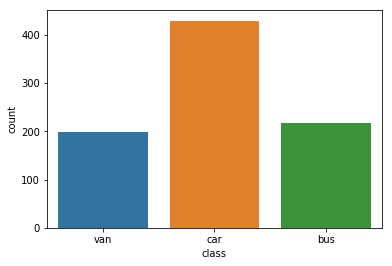

In [8]:
sns.countplot(vehicle_data['class'])

- we have the output class in the ratio 200 : 400 : 200 which is equal to 1:2:1
- so Intuitively , if take 4 nearest neighbours , it may provide a better result in predicting the missing data.

In [90]:
vehicle_data_copy = vehicle_data.copy() # take a copy of the dataset
X_copy = vehicle_data_copy.drop('class', axis=1)  # take X values
X_column_names = vehicle_data_copy.columns.values.tolist()
y_copy = vehicle_data_copy['class'] # take y values
X_column_names.remove('class')

In [91]:
X_copy.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio  
0             187.0            197  
1             189.0            199  
2             188.0            196  
3             199.0            207  
4             180.0            183

In [92]:
knn_estimator = KNeighborsRegressor(n_neighbors=4) # create KNN regressor with 4 nearest neighbours
imputer = IterativeImputer(estimator = knn_estimator, random_state=0) #create the imputer-SKlearn-Iterative-Imputer

In [93]:
imputer.get_params

<bound method BaseEstimator.get_params of IterativeImputer(add_indicator=False,
                 estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                               metric='minkowski',
                                               metric_params=None, n_jobs=None,
                                               n_neighbors=4, p=2,
                                               weights='uniform'),
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=0,
                 sample_posterior=False, tol=0.001, verbose=0)>

The imputer is formed as desired 

- imputing nan values
- KNN regressor with 4 neighbours


In [84]:
#impute the X data
X_imputed = imputer.fit_transform(X_copy)

In [94]:
# create a data frame with the imputed data
X_imputed_df = pd.DataFrame(data = X_imputed ,columns = X_column_names ) 
y_df = pd.DataFrame(y_copy)
imputed_df = pd.concat([X_imputed_df, y_df], axis=1)

In [95]:
#verify if all nan values are replaced
imputed_df[imputed_df.isnull().any(axis=1)]

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

<font color='blue'>All the nan values have been replaced successfully .

# Outlier detection and Correction

- From the describe method , we saw that the data is mostly normaly distributed.
- It will be easy and logical to find the outliers with the Z score
- Z-score above 3 will tell us that the data does not fall under 99 percent of the population

In [144]:
#utility function to detect outliers with the help of z score
def detect_outlier(data_1):
    """ detect outlier from the normally distributed data with z score above 3 """
    outliers=[]
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [145]:
def print_outliers_in_dataFrame(data_frame):
    for key , value in data_frame.iteritems():
        outliers = detect_outlier(value)
        print(key,outliers) 

In [146]:
X_imputed_copy  = imputed_df.drop('class', axis=1)
print_outliers_in_dataFrame(X_imputed_copy)

compactness [119.0]
circularity []
distance_circularity []
radius_ratio [306.0, 322.0, 333.0]
pr.axis_aspect_ratio [103.0, 126.0, 126.0, 133.0, 102.0, 138.0, 97.0, 105.0]
max.length_aspect_ratio [52.0, 49.0, 52.0, 48.0, 43.0, 49.0, 25.0, 46.0, 55.0]
scatter_ratio []
elongatedness []
pr.axis_rectangularity [29.0]
max.length_rectangularity []
scaled_variance [288.0, 320.0, 285.0, 285.0, 287.0, 285.0]
scaled_variance.1 [998.0, 982.0, 987.0, 1018.0]
scaled_radius_of_gyration []
scaled_radius_of_gyration.1 [127.0, 118.0, 119.0, 97.0, 135.0, 99.0]
skewness_about [22.0, 22.0, 22.0, 22.0]
skewness_about.1 [41.0, 40.0]
skewness_about.2 []
hollows_ratio []


In [147]:
# check the outliers to see if they are incorrect values
imputed_df[imputed_df['pr.axis_aspect_ratio']>96]

compactness  circularity  distance_circularity  radius_ratio  \
4           85.0         44.0                  70.0         205.0   
37          90.0         48.0                  86.0         306.0   
100         82.0         45.0                  66.0         252.0   
135         89.0         47.0                  83.0         322.0   
291         89.0         45.0                  81.0         246.0   
388         94.0         47.0                  85.0         333.0   
523         90.0         43.0                  81.0         231.0   
706         82.0         43.0                  70.0         250.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
4                   103.0                     52.0          149.0   
37                  126.0                     49.0          153.0   
100                 126.0                     52.0          148.0   
135                 133.0                     48.0          158.0   
291                 102.0                     43.0          155.0   
388                 138.0                     49.0          155.0   
523                  97.0                     46.0          150.0   
706                 105.0                     55.0          139.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
4             45.0                    19.0                      144.0   
37            44.0                    19.0                      156.0   
100           45.0                    19.0                      144.0   
135           43.0                    20.0                      163.0   
291           44.0                    20.0                      160.0   
388           43.0                    19.0                      155.0   
523           45.0                    19.0                      149.0   
706           48.0                    18.0                      145.0   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
4              241.0              325.0                      188.0   
37             272.0              346.0                      200.0   
100            237.0              326.0                      185.0   
135            229.0              364.0                      176.0   
291            200.0              347.0                      177.0   
388            320.0              354.0                      187.0   
523            200.0              332.0                      164.0   
706            231.0              289.0                      172.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
4                          127.0             9.0              11.0   
37                         118.0             0.0              15.0   
100                        119.0             1.0               1.0   
135                         97.0             0.0              14.0   
291                         90.0             9.0              17.0   
388                        135.0            12.0               9.0   
523                         91.0             5.0               9.0   
706                         99.0             4.0               9.0   

     skewness_about.2  hollows_ratio class  
4               180.0          183.0   bus  
37              185.0          194.0   van  
100             181.0          185.0   bus  
135             184.0          194.0   van  
291             183.0          192.0   van  
388             188.0          196.0   van  
523             186.0          196.0   van  
706             190.0          199.0   van

we cannot find any relation in the data. so the outlier doesnot follow any pattern.
Also the data does not look like incorrect entry.

In [148]:
def impute_outlier_with_null(data_frame):
    z_score = np.abs(stats.zscore(data_frame))
    data_frame[z_score > 3] = np.nan
    return data_frame
           

In [149]:
outlier_null_df = impute_outlier_with_null(X_imputed_copy)

In [150]:
# check the outliers to see if they are incorrect values
outlier_null_df[outlier_null_df['pr.axis_aspect_ratio']>96]

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio]
Index: []

No outliers are present in the data currently

In [153]:
#impute the outlier data which were given null with the KNN regressor
X_outlier_imputed = imputer.fit_transform(outlier_null_df)

In [155]:
X_outlier_imputed_df = pd.DataFrame(data = X_outlier_imputed ,columns = X_column_names ) 

In [156]:
print_outliers_in_dataFrame(X_outlier_imputed_df)

compactness []
circularity []
distance_circularity []
radius_ratio []
pr.axis_aspect_ratio []
max.length_aspect_ratio [22.0, 19.0, 22.0]
scatter_ratio []
elongatedness []
pr.axis_rectangularity []
max.length_rectangularity []
scaled_variance []
scaled_variance.1 [968.0]
scaled_radius_of_gyration []
scaled_radius_of_gyration.1 []
skewness_about [21.0, 21.0, 21.0, 21.0, 21.0]
skewness_about.1 []
skewness_about.2 []
hollows_ratio []


<font color='blue'>The number of outliers have reduced drastically after the Imputation with KNN regressor

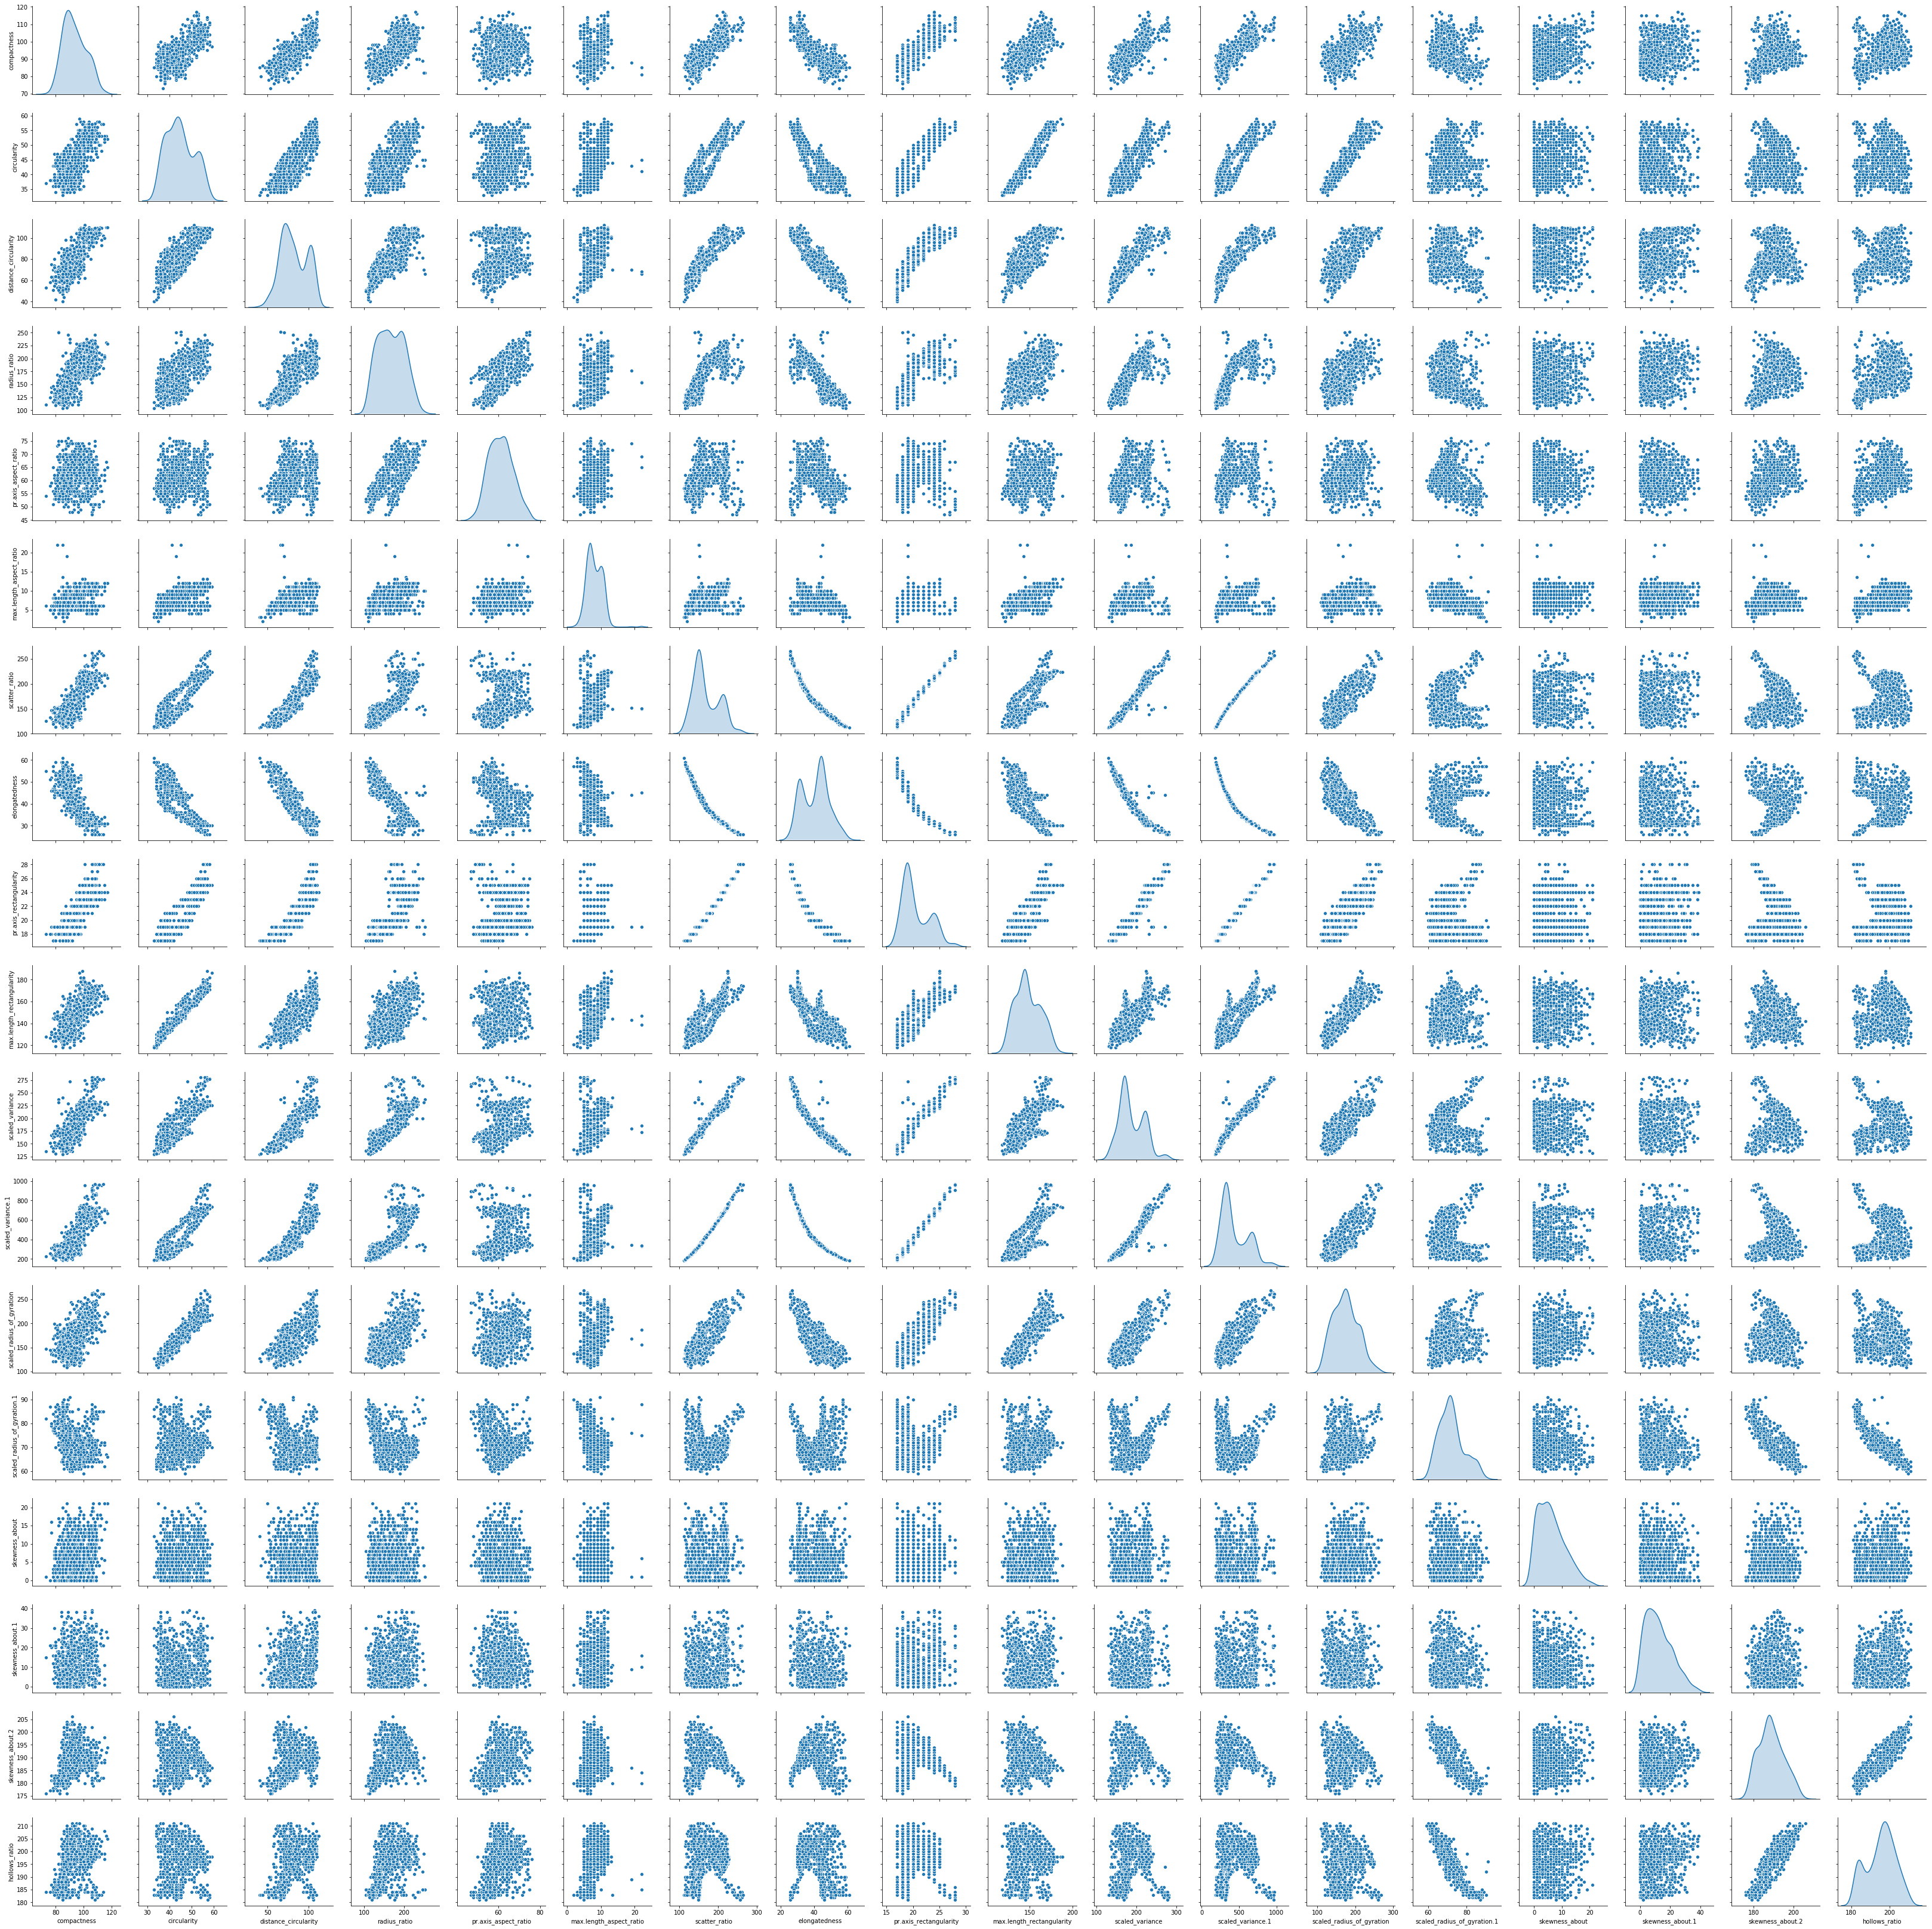

In [160]:
sns.pairplot(X_outlier_imputed_df , diag_kind ='kde')

- The data looks normally distributed for most of the fields
- we may need to do the scaling to smoothen some of the curves
- Many field looks highly correlated with others
- Highly correlated fields can be reduced by feature elimination techniques

In [178]:
vehicle_df = pd.concat([X_outlier_imputed_df, y_df], axis=1)
#Target column is encoded with 0 and 1
vehicle_df['class'].value_counts()


car    429
bus    218
van    199
Name: class, dtype: int64

In [179]:
target_map = {'class': {'van': 0, 'bus': 1,'car':2}}
vehicle_preprocessed_df = vehicle_df.replace(target_map)
vehicle_preprocessed_df.head()

compactness  circularity  distance_circularity  radius_ratio  \
0         95.0         48.0                  83.0         178.0   
1         91.0         41.0                  84.0         141.0   
2        104.0         50.0                 106.0         209.0   
3         93.0         41.0                  82.0         159.0   
4         85.0         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                     10.0          162.0   
1                  57.0                      9.0          149.0   
2                  66.0                     10.0          207.0   
3                  63.0                      9.0          144.0   
4                  71.5                     13.5          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                      159.0   
1           45.0                    19.0                      143.0   
2           32.0                    23.0                      158.0   
3           46.0                    19.0                      143.0   
4           45.0                    19.0                      144.0   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                         82.0             9.0              11.0   

   skewness_about.2  hollows_ratio  class  
0             187.0          197.0      0  
1             189.0          199.0      0  
2             188.0          196.0      2  
3             199.0          207.0      0  
4             180.0          183.0      1

# Trail1 : Traditional classifiers and ensemble techniques

In [189]:
def cross_validation_scores(model , X_train, y_train):
    """Gives the cross validation Accurancy mean and standard deviation"""
    
    accuracies_lr= cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10) 
    accuracies_lr_mean=accuracies_lr.mean()*100
    print("Mean Accuracy for cross validation = ",accuracies_lr_mean)

    accuracies_lr_std=accuracies_lr.std()*100
    print("Standard Deviation for cross validation = ",accuracies_lr_std)

In [190]:
def get_auc_roc_score(model, X_train, y_train) :
    """Gives the Auc Roc Scores from cross validation"""
    
    mean_roc_auc_score = cross_val_score(estimator = model, X = X_train, y = y_train, scoring="roc_auc", cv = 7).mean()
    std_roc_auc_score = cross_val_score(estimator = model, X = X_train, y = y_train, scoring="roc_auc", cv = 7).std()

    print("Mean AUC ROC Score:",mean_roc_auc_score)
    print("Std Dev AUC ROC Score:",std_roc_auc_score)


In [191]:
def train_classifier(classifier, X_train, X_test, y_train, y_test):
    """Trains the classifier algorithm , cross validates and prints the results"""
    
    classifier.fit(X_train,y_train) # train model
    y_pred=classifier.predict(X_test) # test model
    test_score = classifier.score(X_test, y_test) # get testing score
    train_score = classifier.score(X_train,y_train) # get training score
    print("training score = " ,train_score)
    print("testing score = " ,test_score)
    
    cross_validation_scores(classifier , X_train, y_train) # get cross validation scores

In [204]:
#List of classifiers algorithms to try
classifiers = [
    LogisticRegression(solver='liblinear'),
    KNeighborsClassifier(n_neighbors=3),
    SVC(kernel="rbf", C=0.025, probability=True, gamma = 0.025),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators = 10),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier()
    ]

In [205]:
#utility method to iterate over all the algorithms
def train_and_print_training_scores(classifiers,X_train, X_test, y_train, y_test):
    """Trains the array of classifier algorithm , cross validates and prints the results"""
    for classifier in classifiers: #iterate through all classifiers
        name = classifier.__class__.__name__ # get the classifier name
    
        print("="*30)
        print(name)
    
        print('****Results****')
        
        train_classifier(classifier, X_train, X_test, y_train, y_test) # train the model
        

In [206]:
def print_classification_report_loan_class(classifiers,X_train, X_test, y_train, y_test):
    """Trains the array of classifier algorithm , prints the classification results"""
    # Logging for Visual Comparison
    log_cols=["Classifier", "FN", "TP" , "Precision" , "Recall" , "F1_score"]
    log = pd.DataFrame(columns=log_cols)
    
    for classifier in classifiers: #iterate through all classifiers
        name = classifier.__class__.__name__ # get the classifier name
        classifier.fit(X_train,y_train) # train model
        y_pred=classifier.predict(X_test) # test model
        
        label_for_loan = [1]
        
        confusion_mat = confusion_matrix(y_test,y_pred) #get the confusion matrix
        precision = metrics.precision_score(y_test, y_pred, average='weighted', labels=label_for_loan)
        recall = metrics.recall_score(y_test, y_pred, average='weighted', labels=label_for_loan)
        f1_score = metrics.f1_score(y_test, y_pred, average='weighted', labels=label_for_loan)


        False_Negative  = confusion_mat[1,0]
        True_Positive = confusion_mat[1,1]
        
        log_entry = pd.DataFrame([[name, False_Negative, True_Positive ,precision ,recall ,f1_score ]], columns=log_cols)
        log = log.append(log_entry)
   
    
    print(log.sort_values(by=['F1_score'], ascending=False))

In [207]:
#split the X and Y columns
X = vehicle_preprocessed_df.drop('class', axis=1)
y = vehicle_preprocessed_df['class']

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [209]:
#train the given set of classifiers and print the results
train_and_print_training_scores(classifiers , X_train, X_test, y_train, y_test)

LogisticRegression
****Results****
training score =  0.9662162162162162
testing score =  0.9606299212598425
Mean Accuracy for cross validation =  95.44827073528357
Standard Deviation for cross validation =  2.5085443431889813
KNeighborsClassifier
****Results****
training score =  0.9442567567567568
testing score =  0.8228346456692913
Mean Accuracy for cross validation =  87.32978559783444
Standard Deviation for cross validation =  4.05442533551136
SVC
****Results****
training score =  0.5
testing score =  0.5236220472440944
Mean Accuracy for cross validation =  50.00297353553375
Standard Deviation for cross validation =  0.38568945268131943
DecisionTreeClassifier
****Results****
training score =  1.0
testing score =  0.8858267716535433
Mean Accuracy for cross validation =  90.33573779568735
Standard Deviation for cross validation =  3.7131015764868707
RandomForestClassifier
****Results****
training score =  0.9983108108108109
testing score =  0.9212598425196851
Mean Accuracy for cross 

In [219]:
print_classification_report_loan_class(classifiers,X_train, X_test, y_train, y_test)

                   Classifier FN  TP  Precision    Recall  F1_score
0  GradientBoostingClassifier  0  56   0.965517  0.949153  0.957265
0          LogisticRegression  1  56   0.949153  0.949153  0.949153
0               XGBClassifier  0  56   0.949153  0.949153  0.949153
0      RandomForestClassifier  0  56   0.903226  0.949153  0.925620
0      DecisionTreeClassifier  1  54   0.870968  0.915254  0.892562
0        KNeighborsClassifier  3  45   0.762712  0.762712  0.762712
0          AdaBoostClassifier  0  39   0.866667  0.661017  0.750000
0                         SVC  0   0   0.000000  0.000000  0.000000


In the first trail,

the best performer is logistic regression with 
- testing score =  0.9606299212598425
- Mean Accuracy for cross validation =  95.44827073528357
- F1 score : 0.949153

# Trial 2 : scaling with Robust scalar and zscore

In [215]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_copy))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test_copy))

In [216]:
X_train_scaled.head()

0    1         2         3       4     5         6         7     8   \
0  0.333333  0.2  0.750000  0.758465  0.5625  0.00  0.657277 -0.615385  0.50   
1  0.166667  0.4  0.857143  0.830700  0.6875  0.25  0.901408 -0.846154  0.75   
2 -1.083333 -0.7 -0.821429 -0.939052 -0.8125 -0.50 -0.600939  0.846154 -0.50   
3 -0.583333 -0.6  0.321429  0.144470 -0.3125  0.25  0.225352 -0.307692  0.00   
4 -1.000000  0.3 -0.392857 -0.397291  0.3125 -0.50 -0.112676  0.076923 -0.25   

         9     10        11        12        13        14        15     16  \
0  0.217391  0.60  0.648165 -0.102041 -0.606061 -0.571429  1.500000  0.250   
1  0.217391  0.98  0.941808  0.571429  0.363636  0.000000 -0.142857 -0.375   
2 -0.913043 -0.72 -0.487019 -0.857143  1.212121  0.428571 -0.428571 -1.375   
3 -0.608696  0.24  0.225604 -0.530612 -0.484848  0.285714  1.571429  0.500   
4  0.043478 -0.14 -0.089526  0.428571  0.484848  0.000000 -0.785714 -0.750   

         17  
0  0.272727  
1 -0.363636  
2 -1.181818  
3  0.454545  
4 -0.818182

In [217]:
X_test_scaled.head()

0         1         2     3         4         5         6         7   \
0 -0.250000  0.222222 -0.153846 -0.66 -0.774194  1.000000  0.062827  0.000000   
1  1.333333  0.888889  0.615385  0.46 -0.387097 -1.333333  1.465969 -1.098039   
2  0.583333 -0.333333 -0.153846  0.78  1.290323 -1.000000  0.397906 -0.549020   
3  0.583333  0.555556  0.038462  0.80  1.161290 -0.666667  0.544503 -0.627451   
4  0.166667 -0.222222  0.653846  0.62  0.516129  0.333333  0.439791 -0.470588   

         8         9         10        11        12        13     14  \
0  0.000000  0.703297 -0.152174  0.021590 -0.032787  0.714286 -0.750   
1  1.666667  0.571429  1.782609  1.619235  0.972678  1.428571 -0.750   
2  0.333333 -0.307692  0.521739  0.453386 -0.469945  0.000000  0.125   
3  0.333333  0.483516  0.565217  0.602552  0.557377  0.142857 -0.375   
4  0.333333 -0.175824  0.413043  0.433759 -0.513661 -0.714286 -0.625   

         15        16        17  
0  0.372093 -0.666667 -0.444444  
1  0.651163 -0.111111 -1.111111  
2  0.651163  1.000000  0.111111  
3  0.093023  1.111111  0.333333  
4  1.581395  0.555556  0.444444

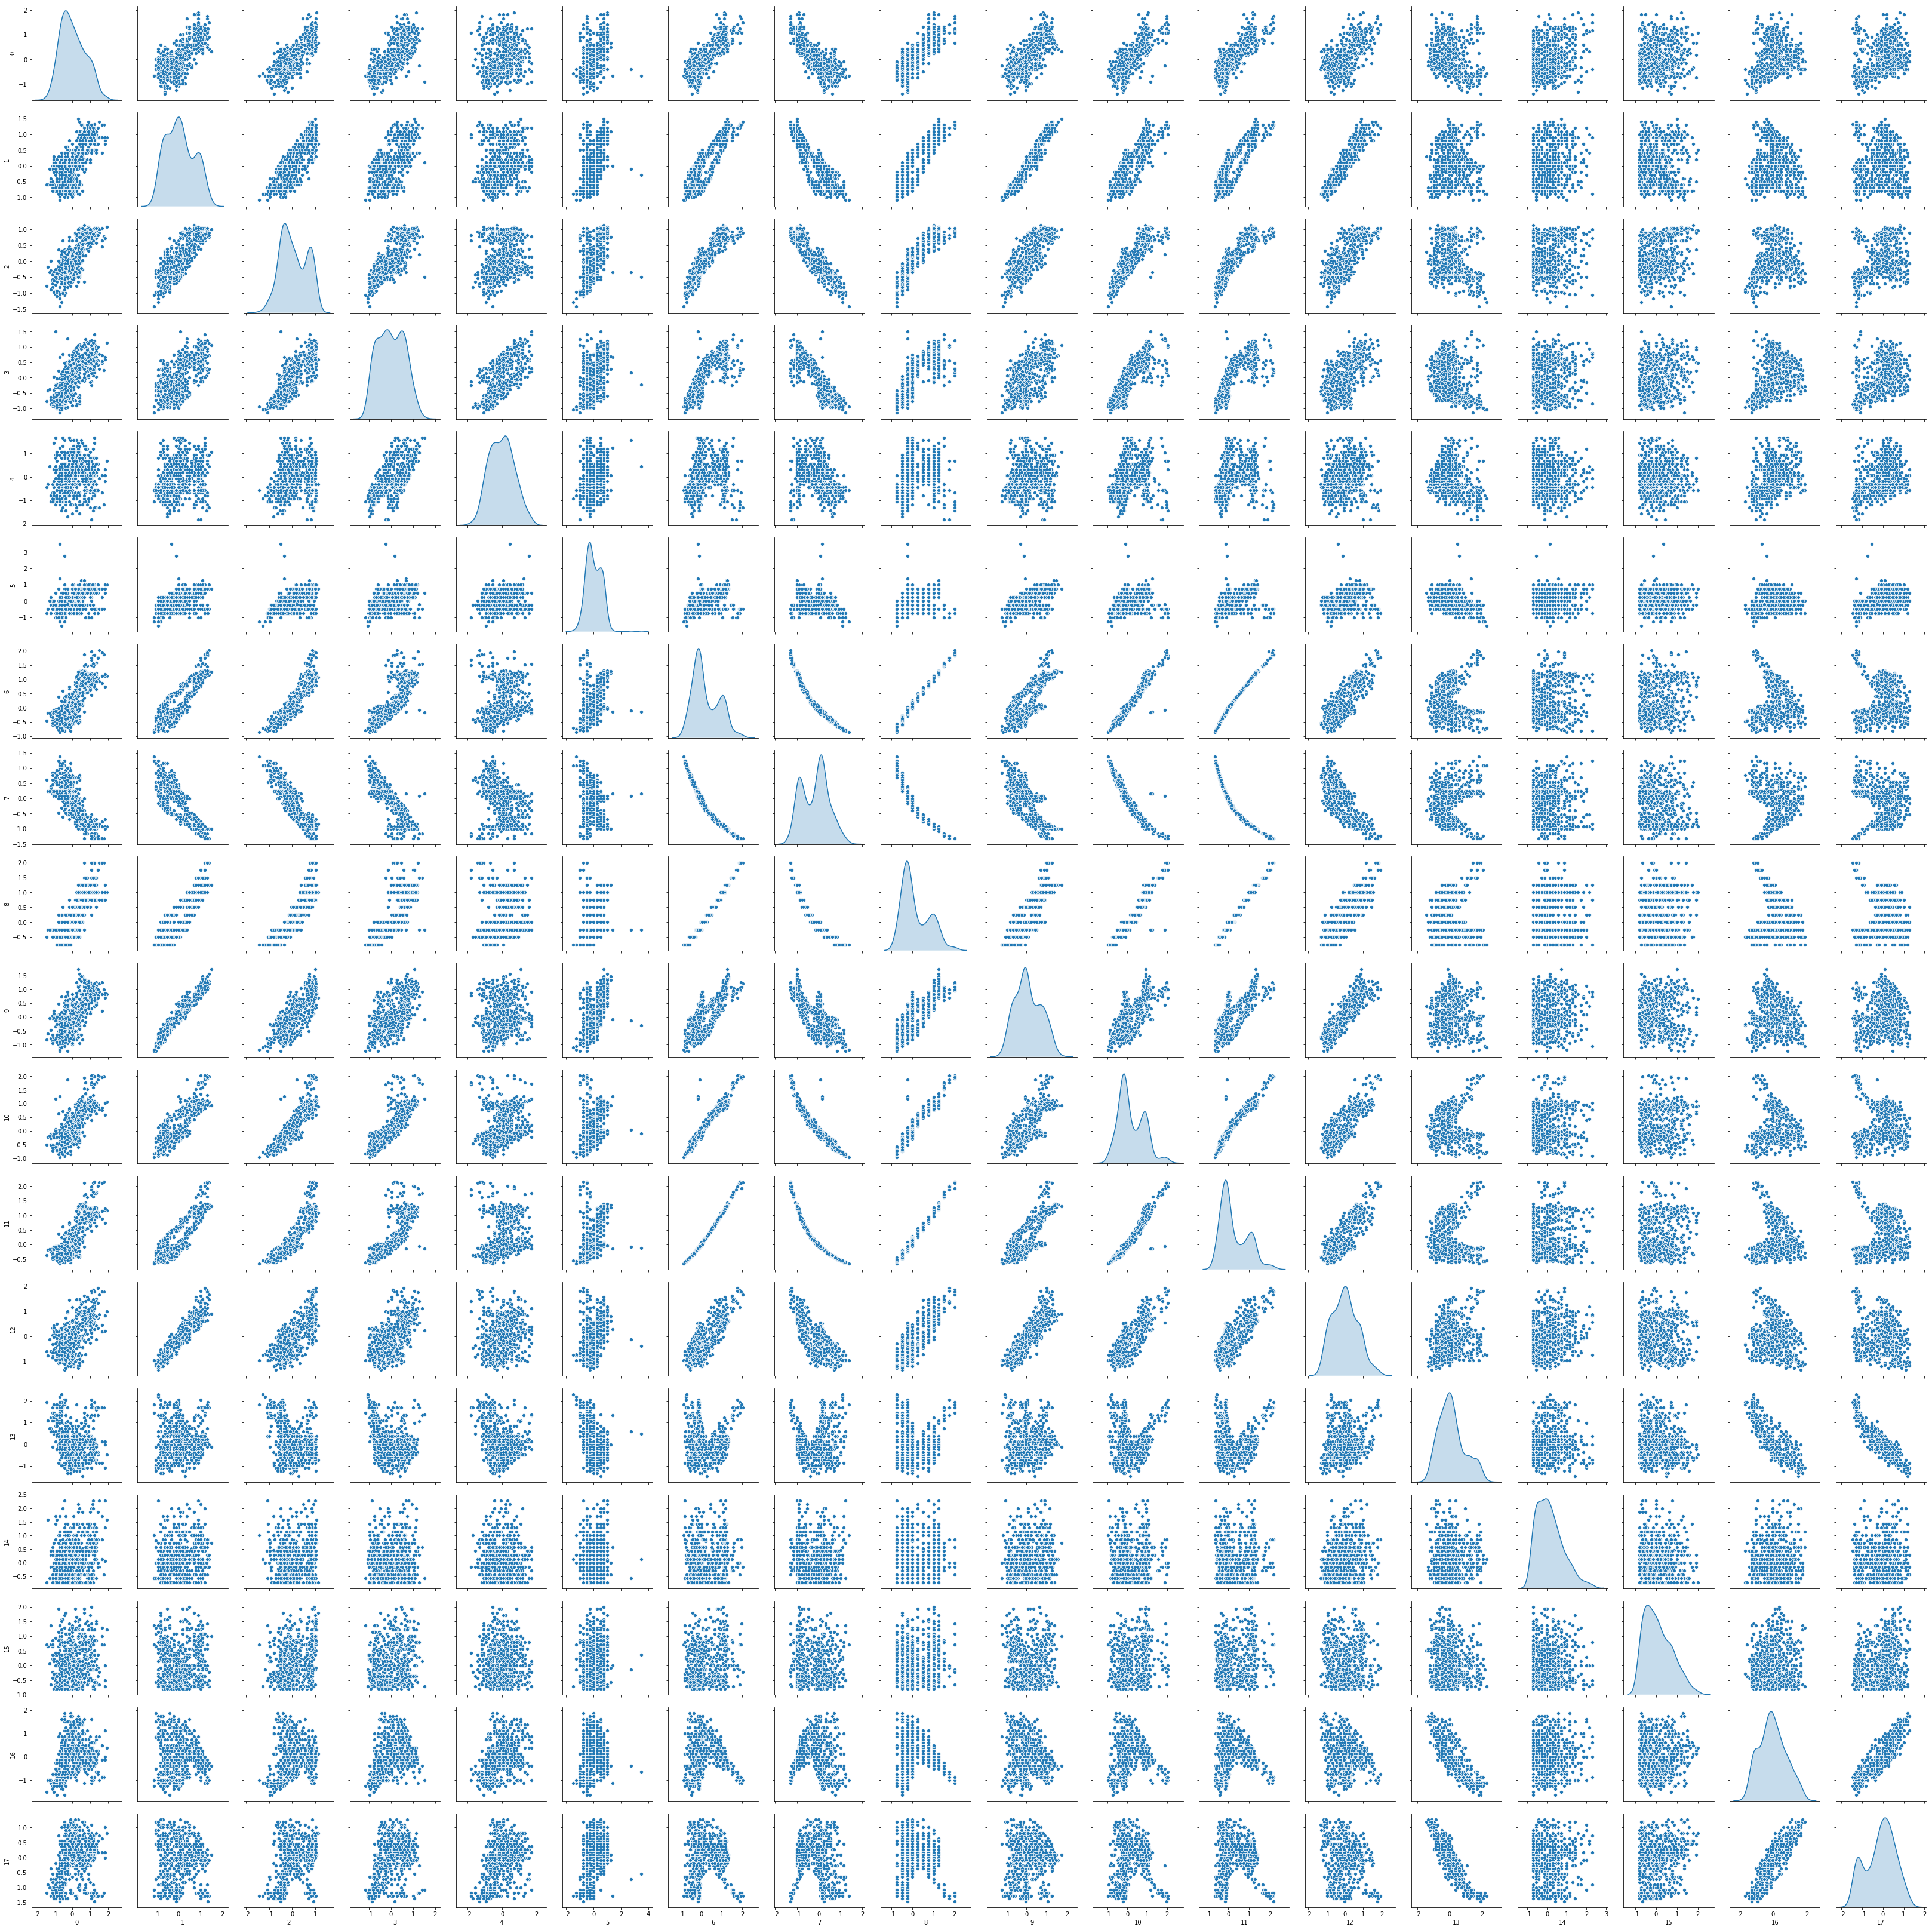

In [297]:
sns.pairplot(X_train_scaled, diag_kind='kde')

In [218]:
#train the given set of classifiers and print the results
train_and_print_training_scores(classifiers , X_train_scaled, X_test_scaled, y_train, y_test)

LogisticRegression
****Results****
training score =  0.9408783783783784
testing score =  0.905511811023622
Mean Accuracy for cross validation =  93.0859966983502
Standard Deviation for cross validation =  1.8833356519310525
KNeighborsClassifier
****Results****
training score =  0.9662162162162162
testing score =  0.9251968503937008
Mean Accuracy for cross validation =  92.37032821680151
Standard Deviation for cross validation =  3.8063650235219093
SVC
****Results****
training score =  0.5
testing score =  0.5236220472440944
Mean Accuracy for cross validation =  50.00297353553375
Standard Deviation for cross validation =  0.38568945268131943
DecisionTreeClassifier
****Results****
training score =  1.0
testing score =  0.8346456692913385
Mean Accuracy for cross validation =  88.68954238313492
Standard Deviation for cross validation =  4.135389247672128
RandomForestClassifier
****Results****
training score =  0.9983108108108109
testing score =  0.9251968503937008
Mean Accuracy for cross v

In [220]:
print_classification_report_loan_class(classifiers,X_train_scaled, X_test_scaled, y_train, y_test)

                   Classifier FN  TP  Precision    Recall  F1_score
0  GradientBoostingClassifier  0  56   0.949153  0.949153  0.949153
0               XGBClassifier  0  56   0.949153  0.949153  0.949153
0      RandomForestClassifier  1  55   0.948276  0.932203  0.940171
0        KNeighborsClassifier  1  56   0.888889  0.949153  0.918033
0          LogisticRegression  3  52   0.812500  0.881356  0.845528
0      DecisionTreeClassifier  3  49   0.859649  0.830508  0.844828
0          AdaBoostClassifier  0  38   0.904762  0.644068  0.752475
0                         SVC  0   0   0.000000  0.000000  0.000000


In the second trial , 

XGBClassifier has better performance :

- testing score =  0.9251968503937008
- Mean Accuracy for cross validation =  94.57178012242764
- F1_score = 0.949153

In [223]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
scaler = RobustScaler()
X_train_zscore_scaled = X_train_copy.apply(stats.zscore)
X_test_zscore_scaled = X_test_copy.apply(stats.zscore)

In [224]:
X_train_zscore_scaled.head()

compactness  circularity  distance_circularity  radius_ratio  \
350     0.398843     0.178686              1.180429      1.259937   
40      0.151925     0.500334              1.368691      1.382608   
89     -1.699958    -1.268730             -1.580751     -1.622820   
427    -0.959205    -1.107906              0.427380      0.217238   
353    -1.576500     0.339510             -0.827702     -0.702791   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
350              0.823021                -0.061452       0.678261   
40               0.999138                 0.386298       1.064828   
89              -1.114269                -0.956952      -1.314041   
427             -0.409800                 0.386298      -0.005663   
353              0.470786                -0.956952      -0.540909   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
350      -0.746756                0.535068                   0.206748   
40       -1.127722                0.918555                   0.206748   
89        1.666030               -0.998880                  -1.591143   
427      -0.238801               -0.231906                  -1.107096   
353       0.396143               -0.615393                  -0.069851   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
350         0.616105           0.583237                  -0.185296   
40          1.220575           1.042614                   0.805788   
89         -1.483633          -1.192646                  -1.296510   
427         0.043449          -0.077817                  -0.815985   
353        -0.561021          -0.570807                   0.595558   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
350                    -0.938658       -1.090651          2.144357   
40                      0.289716       -0.226885         -0.391695   
89                      1.364542        0.420940         -0.832747   
427                    -0.785111        0.204999          2.254621   
353                     0.443262       -0.226885         -1.384063   

     skewness_about.2  hollows_ratio  
350          0.320983       0.560828  
40          -0.490209      -0.360326  
89          -1.788117      -1.544666  
427          0.645459       0.824015  
353         -0.976925      -1.018293

In [225]:
#train the given set of classifiers and print the results
train_and_print_training_scores(classifiers , X_train_scaled, X_test_scaled, y_train, y_test)

LogisticRegression
****Results****
training score =  0.9408783783783784
testing score =  0.905511811023622
Mean Accuracy for cross validation =  93.0859966983502
Standard Deviation for cross validation =  1.8833356519310525
KNeighborsClassifier
****Results****
training score =  0.9662162162162162
testing score =  0.9251968503937008
Mean Accuracy for cross validation =  92.37032821680151
Standard Deviation for cross validation =  3.8063650235219093
SVC
****Results****
training score =  0.5
testing score =  0.5236220472440944
Mean Accuracy for cross validation =  50.00297353553375
Standard Deviation for cross validation =  0.38568945268131943
DecisionTreeClassifier
****Results****
training score =  1.0
testing score =  0.8464566929133859
Mean Accuracy for cross validation =  89.3445097255119
Standard Deviation for cross validation =  3.6490427116699093
RandomForestClassifier
****Results****
training score =  1.0
testing score =  0.8937007874015748
Mean Accuracy for cross validation =  92

In [226]:
print_classification_report_loan_class(classifiers,X_train_zscore_scaled, X_test_zscore_scaled, y_train, y_test)

                   Classifier FN  TP  Precision    Recall  F1_score
0  GradientBoostingClassifier  0  56   0.933333  0.949153  0.941176
0               XGBClassifier  0  56   0.933333  0.949153  0.941176
0          LogisticRegression  1  56   0.918033  0.949153  0.933333
0      RandomForestClassifier  0  58   0.878788  0.983051  0.928000
0        KNeighborsClassifier  1  57   0.863636  0.966102  0.912000
0      DecisionTreeClassifier  1  53   0.868852  0.898305  0.883333
0          AdaBoostClassifier  0  39   0.866667  0.661017  0.750000
0                         SVC  0   0   0.000000  0.000000  0.000000


In third trial ,

the best performer is XGBClassifier

- testing score =  0.9251968503937008
- Mean Accuracy for cross validation =  94.57178012242764
- F1_score = 0.941176


# Dimensionality Reduction Techniques : feature extraction - PCA6, PCA8,LDA

In [228]:
XScaled = X.copy().apply(stats.zscore)
XScaled.head()

compactness  circularity  distance_circularity  radius_ratio  \
0     0.163056     0.508467              0.057370      0.293799   
1    -0.325030    -0.626635              0.120815     -0.851825   
2     1.261249     0.832782              1.516603      1.253646   
3    -0.080987    -0.626635             -0.006075     -0.294494   
4    -1.057159    -0.140163             -0.767413      1.129795   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0              1.881175                 0.822470      -0.205880   
1             -0.746465                 0.372835      -0.597164   
2              0.830119                 0.822470       1.148566   
3              0.304591                 0.372835      -0.747658   
4              1.793587                 2.396192      -0.597164   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0       0.136532               -0.224802                   0.758332   
1       0.520805               -0.611351                  -0.344578   
2      -1.144378                0.934847                   0.689401   
3       0.648896               -0.611351                  -0.344578   
4       0.520805               -0.611351                  -0.275646   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0        -0.401340          -0.344937                   0.285505   
1        -0.595586          -0.623589                  -0.513829   
2         1.120253           1.110878                   1.392275   
3        -0.919330          -0.743012                  -1.466881   
4         1.702991          -0.652023                   0.408480   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                    -0.341034       -0.064365          0.391469   
1                    -0.030636        0.561530          0.164826   
2                     0.124563        1.604690         -0.401783   
3                    -1.427425       -0.064365         -0.288461   
4                     1.521352        0.561530         -0.175140   

   skewness_about.2  hollows_ratio  
0         -0.313278       0.183957  
1          0.011767       0.452977  
2         -0.150756       0.049447  
3          1.636988       1.529056  
4         -1.450933      -1.699181

In [229]:
XScaled.shape

(846, 18)

In [230]:
pca = PCA(n_components=18)
pca.fit(XScaled)

PCA(copy=True, iterated_power='auto', n_components=18, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [231]:
print(pca.explained_variance_)

[9.74790757e+00 3.33434493e+00 1.19333106e+00 1.14817656e+00
 8.91167541e-01 7.09655855e-01 3.34577795e-01 2.22117463e-01
 1.17505960e-01 8.95760282e-02 6.49798348e-02 5.59513701e-02
 4.24718177e-02 2.92198342e-02 2.05955927e-02 1.28931033e-02
 6.34028046e-03 4.89182561e-04]


In [232]:
print(pca.components_)

[[ 2.72360103e-01  2.89500594e-01  3.02300828e-01  2.69985125e-01
   9.63540025e-02  1.78913862e-01  3.11318138e-01 -3.09166472e-01
   3.08278893e-01  2.78025578e-01  3.02215092e-01  3.08573247e-01
   2.64121502e-01 -4.47533145e-02  4.11752772e-02  5.90123409e-02
   3.62022327e-02  8.24467752e-02]
 [-9.05618886e-02  1.35027966e-01 -5.11383365e-02 -1.96323538e-01
  -2.49054235e-01 -9.78598194e-02  7.16367097e-02 -9.15356798e-03
   8.46388260e-02  1.19767853e-01  7.25696376e-02  7.63013835e-02
   2.09110726e-01  5.03290975e-01 -3.11265520e-02 -9.31034557e-02
  -5.05912468e-01 -5.10272284e-01]
 [-3.62495846e-02 -1.97797543e-01  6.90134393e-02  4.91898197e-02
  -8.21318438e-02 -1.41334449e-01  1.07522957e-01 -9.14937662e-02
   1.05654003e-01 -2.08044818e-01  1.36493951e-01  1.08833446e-01
  -2.07057282e-01  6.60742489e-02 -5.50992155e-01  6.82073312e-01
  -5.92430198e-02 -3.52263289e-02]
 [-1.67481617e-01  3.32428039e-02 -9.91435730e-02  2.69751807e-01
   6.36920708e-01 -1.74256827e-01 -1.

In [233]:
print(pca.explained_variance_ratio_)

[5.40910290e-01 1.85022424e-01 6.62178056e-02 6.37121876e-02
 4.94507862e-02 3.93787233e-02 1.85656840e-02 1.23252729e-02
 6.52039247e-03 4.97056369e-03 3.60572369e-03 3.10473521e-03
 2.35675637e-03 1.62140530e-03 1.14284711e-03 7.15436847e-04
 3.51821447e-04 2.71446851e-05]


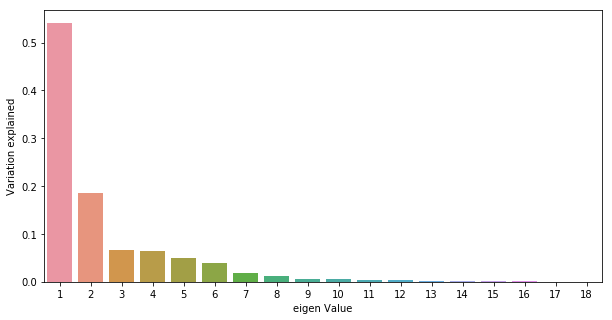

In [244]:
plt.figure(figsize=(10,5))
sns.barplot(x = list(range(1,19)), y= pca.explained_variance_ratio_)
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

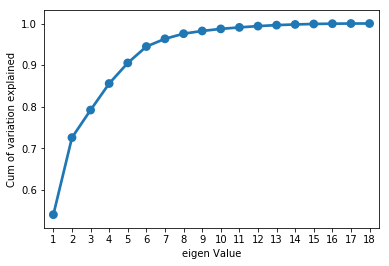

In [246]:
sns.pointplot(x= list(range(1,19)),y =np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

<font color ='blue'> From the above plots it is clear that taking 6 principal components will provide more than 95 percent of the variation in the original data

In [248]:
pca6 = PCA(n_components=6)
pca6.fit(XScaled)
print(pca6.components_)
print(pca6.explained_variance_ratio_)
Xpca6 = pca6.transform(XScaled)

[[ 2.72360103e-01  2.89500594e-01  3.02300828e-01  2.69985125e-01
   9.63540025e-02  1.78913862e-01  3.11318138e-01 -3.09166472e-01
   3.08278893e-01  2.78025578e-01  3.02215092e-01  3.08573247e-01
   2.64121502e-01 -4.47533145e-02  4.11752772e-02  5.90123409e-02
   3.62022327e-02  8.24467752e-02]
 [-9.05618886e-02  1.35027966e-01 -5.11383365e-02 -1.96323538e-01
  -2.49054235e-01 -9.78598194e-02  7.16367097e-02 -9.15356798e-03
   8.46388260e-02  1.19767853e-01  7.25696376e-02  7.63013835e-02
   2.09110726e-01  5.03290975e-01 -3.11265520e-02 -9.31034557e-02
  -5.05912468e-01 -5.10272284e-01]
 [-3.62495846e-02 -1.97797543e-01  6.90134393e-02  4.91898197e-02
  -8.21318438e-02 -1.41334449e-01  1.07522957e-01 -9.14937662e-02
   1.05654003e-01 -2.08044818e-01  1.36493951e-01  1.08833446e-01
  -2.07057282e-01  6.60742489e-02 -5.50992155e-01  6.82073312e-01
  -5.92430198e-02 -3.52263289e-02]
 [-1.67481617e-01  3.32428039e-02 -9.91435730e-02  2.69751807e-01
   6.36920708e-01 -1.74256827e-01 -1.

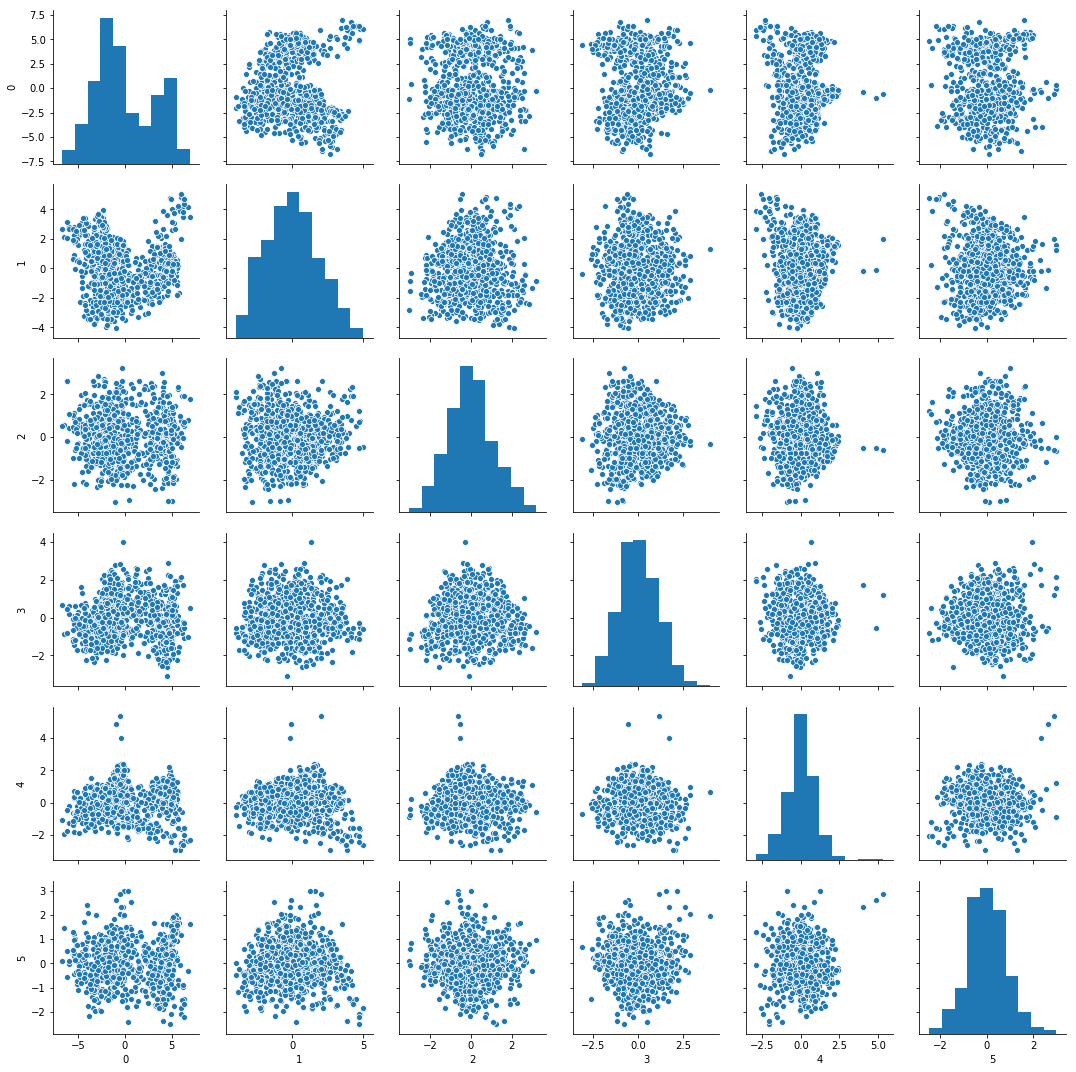

In [249]:
sns.pairplot(pd.DataFrame(Xpca6))

In [250]:
Xpca6.shape

(846, 6)

In [252]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(Xpca6, y, test_size=0.30, random_state=1)

In [253]:
#train the given set of classifiers and print the results
train_and_print_training_scores(classifiers , X_train_pca, X_test_pca, y_train, y_test)

LogisticRegression
****Results****
training score =  0.7787162162162162
testing score =  0.7913385826771654
Mean Accuracy for cross validation =  77.71716037610098
Standard Deviation for cross validation =  2.63249473992457
KNeighborsClassifier
****Results****
training score =  0.9611486486486487
testing score =  0.8976377952755905
Mean Accuracy for cross validation =  89.52287058968287
Standard Deviation for cross validation =  3.655747162049043
SVC
****Results****
training score =  0.5
testing score =  0.5236220472440944
Mean Accuracy for cross validation =  50.00297353553375
Standard Deviation for cross validation =  0.38568945268131943
DecisionTreeClassifier
****Results****
training score =  1.0
testing score =  0.8149606299212598
Mean Accuracy for cross validation =  82.23692413382962
Standard Deviation for cross validation =  5.131491756379674
RandomForestClassifier
****Results****
training score =  0.9983108108108109
testing score =  0.8385826771653543
Mean Accuracy for cross va

In [254]:
print_classification_report_loan_class(classifiers,X_train_pca, X_test_pca, y_train, y_test)

                   Classifier FN  TP  Precision    Recall  F1_score
0        KNeighborsClassifier  3  55   0.846154  0.932203  0.887097
0  GradientBoostingClassifier  2  54   0.843750  0.915254  0.878049
0               XGBClassifier  2  54   0.830769  0.915254  0.870968
0      RandomForestClassifier  3  50   0.847458  0.847458  0.847458
0      DecisionTreeClassifier  6  43   0.826923  0.728814  0.774775
0          AdaBoostClassifier  3  43   0.796296  0.728814  0.761062
0          LogisticRegression  4  44   0.656716  0.745763  0.698413
0                         SVC  0   0   0.000000  0.000000  0.000000


With PCA reduction to 6 , the performance of all the classifiers have significantly dropped.

the highest values have dropped to 88 from 93.

so , Let us check by increasing the number of principal components to 8. 

In [255]:
pca8 = PCA(n_components=8)
pca8.fit(XScaled)
print(pca8.components_)
print(pca8.explained_variance_ratio_)
Xpca8 = pca8.transform(XScaled)

[[ 2.72360103e-01  2.89500594e-01  3.02300828e-01  2.69985125e-01
   9.63540025e-02  1.78913862e-01  3.11318138e-01 -3.09166472e-01
   3.08278893e-01  2.78025578e-01  3.02215092e-01  3.08573247e-01
   2.64121502e-01 -4.47533145e-02  4.11752772e-02  5.90123409e-02
   3.62022327e-02  8.24467752e-02]
 [-9.05618886e-02  1.35027966e-01 -5.11383365e-02 -1.96323538e-01
  -2.49054235e-01 -9.78598194e-02  7.16367097e-02 -9.15356798e-03
   8.46388260e-02  1.19767853e-01  7.25696376e-02  7.63013835e-02
   2.09110726e-01  5.03290975e-01 -3.11265520e-02 -9.31034557e-02
  -5.05912468e-01 -5.10272284e-01]
 [-3.62495846e-02 -1.97797543e-01  6.90134393e-02  4.91898197e-02
  -8.21318438e-02 -1.41334449e-01  1.07522957e-01 -9.14937662e-02
   1.05654003e-01 -2.08044818e-01  1.36493951e-01  1.08833446e-01
  -2.07057282e-01  6.60742489e-02 -5.50992155e-01  6.82073312e-01
  -5.92430198e-02 -3.52263289e-02]
 [-1.67481617e-01  3.32428039e-02 -9.91435730e-02  2.69751807e-01
   6.36920708e-01 -1.74256827e-01 -1.

In [256]:
X_train_pca8, X_test_pca8, y_train, y_test = train_test_split(Xpca8, y, test_size=0.30, random_state=1)

In [257]:
#train the given set of classifiers and print the results
train_and_print_training_scores(classifiers , X_train_pca8, X_test_pca8, y_train, y_test)

LogisticRegression
****Results****
training score =  0.8344594594594594
testing score =  0.8188976377952756
Mean Accuracy for cross validation =  81.93060383278474
Standard Deviation for cross validation =  4.965400204061867
KNeighborsClassifier
****Results****
training score =  0.964527027027027
testing score =  0.9133858267716536
Mean Accuracy for cross validation =  91.16897372009802
Standard Deviation for cross validation =  3.885586687764537
SVC
****Results****
training score =  0.5
testing score =  0.5236220472440944
Mean Accuracy for cross validation =  50.00297353553375
Standard Deviation for cross validation =  0.38568945268131943
DecisionTreeClassifier
****Results****
training score =  1.0
testing score =  0.7992125984251969
Mean Accuracy for cross validation =  85.3036800065623
Standard Deviation for cross validation =  3.6631888810353987
RandomForestClassifier
****Results****
training score =  1.0
testing score =  0.8779527559055118
Mean Accuracy for cross validation =  90.

In [258]:
print_classification_report_loan_class(classifiers,X_train_pca8, X_test_pca8, y_train, y_test)

                   Classifier FN  TP  Precision    Recall  F1_score
0  GradientBoostingClassifier  0  57   0.904762  0.966102  0.934426
0               XGBClassifier  0  57   0.904762  0.966102  0.934426
0        KNeighborsClassifier  1  56   0.861538  0.949153  0.903226
0      RandomForestClassifier  4  50   0.877193  0.847458  0.862069
0          AdaBoostClassifier  2  52   0.787879  0.881356  0.832000
0      DecisionTreeClassifier  4  43   0.811321  0.728814  0.767857
0          LogisticRegression  1  47   0.701493  0.796610  0.746032
0                         SVC  0   0   0.000000  0.000000  0.000000


the best performer is XGBClassifier

- testing score = 0.9094488188976378
- Mean Accuracy for cross validation = 93.22070298481447
- F1_score = 0.934426

In [264]:
lda = LDA(n_components = 2) 

In [265]:
#train_and_print_training_scores(classifiers , X_train_scaled, X_test_scaled, y_train, y_test)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

In [266]:
train_and_print_training_scores(classifiers , X_train_lda, X_test_lda, y_train, y_test)

LogisticRegression
****Results****
training score =  0.9527027027027027
testing score =  0.9291338582677166
Mean Accuracy for cross validation =  95.6092876844361
Standard Deviation for cross validation =  2.038769207493339
KNeighborsClassifier
****Results****
training score =  0.9662162162162162
testing score =  0.9133858267716536
Mean Accuracy for cross validation =  94.75266336501687
Standard Deviation for cross validation =  1.4391792364311276
SVC
****Results****
training score =  0.9543918918918919
testing score =  0.9409448818897638
Mean Accuracy for cross validation =  94.93687389133265
Standard Deviation for cross validation =  2.1363033744279556
DecisionTreeClassifier
****Results****
training score =  1.0
testing score =  0.9251968503937008
Mean Accuracy for cross validation =  94.08034698083607
Standard Deviation for cross validation =  2.850390141803696
RandomForestClassifier
****Results****
training score =  0.9932432432432432
testing score =  0.905511811023622
Mean Accurac

In [267]:
print_classification_report_loan_class(classifiers,X_train_lda, X_test_lda, y_train, y_test)

                   Classifier FN  TP  Precision    Recall  F1_score
0                         SVC  2  53   0.929825  0.898305  0.913793
0      DecisionTreeClassifier  3  53   0.913793  0.898305  0.905983
0          LogisticRegression  2  54   0.885246  0.915254  0.900000
0        KNeighborsClassifier  4  52   0.896552  0.881356  0.888889
0          AdaBoostClassifier  3  50   0.909091  0.847458  0.877193
0      RandomForestClassifier  4  52   0.866667  0.881356  0.873950
0  GradientBoostingClassifier  3  52   0.852459  0.881356  0.866667
0               XGBClassifier  3  52   0.838710  0.881356  0.859504


the best performer is XGBClassifier


# Feature Elimination

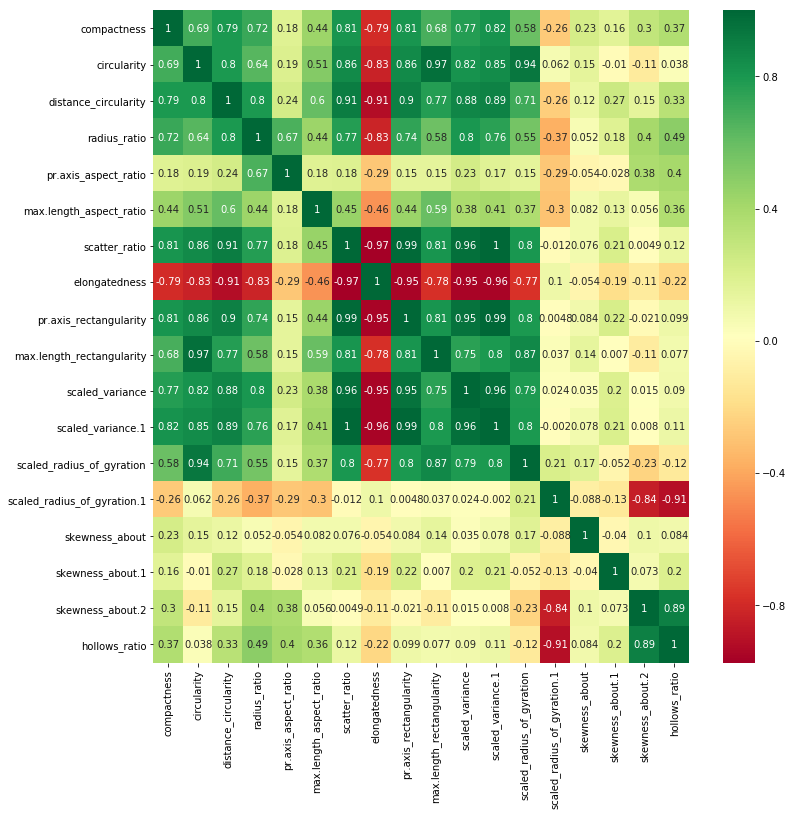

In [270]:
corr = XScaled.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr,annot=True,cmap='RdYlGn')

In [278]:
corr_sum =abs(corr.sum(axis = 1)) 
sorted_correlation = corr_sum.sort_values(ascending = False)

In [287]:
sorted_correlation.head(11)

scatter_ratio                8.975912
distance_circularity         8.975882
elongatedness                8.946273
scaled_variance.1            8.894476
pr.axis_rectangularity       8.887442
scaled_variance              8.706344
circularity                  8.423854
radius_ratio                 8.408758
compactness                  8.298503
max.length_rectangularity    8.163172
scaled_radius_of_gyration    7.567909
dtype: float64

In [292]:
XScaled_copy = XScaled.copy()
X_feature_eliminated = XScaled_copy.drop(columns = ['scatter_ratio','distance_circularity','elongatedness','scaled_variance.1','pr.axis_rectangularity','scaled_variance','circularity','radius_ratio','compactness','max.length_rectangularity','scaled_radius_of_gyration'],axis =1)

In [293]:
X_feature_eliminated.corr()

pr.axis_aspect_ratio  max.length_aspect_ratio  \
pr.axis_aspect_ratio                     1.000000                 0.178659   
max.length_aspect_ratio                  0.178659                 1.000000   
scaled_radius_of_gyration.1             -0.287009                -0.298553   
skewness_about                          -0.053935                 0.082212   
skewness_about.1                        -0.027602                 0.130451   
skewness_about.2                         0.380635                 0.055818   
hollows_ratio                            0.399935                 0.362354   

                             scaled_radius_of_gyration.1  skewness_about  \
pr.axis_aspect_ratio                           -0.287009       -0.053935   
max.length_aspect_ratio                        -0.298553        0.082212   
scaled_radius_of_gyration.1                     1.000000       -0.087607   
skewness_about                                 -0.087607        1.000000   
skewness_about.1                               -0.127864       -0.040190   
skewness_about.2                               -0.844730        0.103151   
hollows_ratio                                  -0.910597        0.084129   

                             skewness_about.1  skewness_about.2  hollows_ratio  
pr.axis_aspect_ratio                -0.027602          0.380635       0.399935  
max.length_aspect_ratio              0.130451          0.055818       0.362354  
scaled_radius_of_gyration.1         -0.127864         -0.844730      -0.910597  
skewness_about                      -0.040190          0.103151       0.084129  
skewness_about.1                     1.000000          0.073080       0.197647  
skewness_about.2                     0.073080          1.000000       0.894020  
hollows_ratio                        0.197647          0.894020       1.000000

In [294]:
X_feature_eliminated_train, X_feature_eliminated_test, y_train, y_test = train_test_split(X_feature_eliminated, y, test_size=0.30, random_state=1)

In [295]:
#train the given set of classifiers and print the results
train_and_print_training_scores(classifiers , X_feature_eliminated_train,X_feature_eliminated_test, y_train, y_test)

LogisticRegression
****Results****
training score =  0.7179054054054054
testing score =  0.6889763779527559
Mean Accuracy for cross validation =  72.15373178709484
Standard Deviation for cross validation =  2.0567933926857807
KNeighborsClassifier
****Results****
training score =  0.8581081081081081
testing score =  0.7480314960629921
Mean Accuracy for cross validation =  71.43534098249715
Standard Deviation for cross validation =  6.562030345914701
SVC
****Results****
training score =  0.5
testing score =  0.5236220472440944
Mean Accuracy for cross validation =  50.00297353553375
Standard Deviation for cross validation =  0.38568945268131943
DecisionTreeClassifier
****Results****
training score =  1.0
testing score =  0.7244094488188977
Mean Accuracy for cross validation =  69.58143898612693
Standard Deviation for cross validation =  3.3407846540644486
RandomForestClassifier
****Results****
training score =  0.9949324324324325
testing score =  0.7795275590551181
Mean Accuracy for cross

In [296]:
print_classification_report_loan_class(classifiers,X_feature_eliminated_train,X_feature_eliminated_test, y_train, y_test)

                   Classifier FN  TP  Precision    Recall  F1_score
0  GradientBoostingClassifier  4  52   0.881356  0.881356  0.881356
0               XGBClassifier  3  53   0.841270  0.898305  0.868852
0        KNeighborsClassifier  5  51   0.850000  0.864407  0.857143
0          AdaBoostClassifier  2  51   0.850000  0.864407  0.857143
0      RandomForestClassifier  3  51   0.822581  0.864407  0.842975
0      DecisionTreeClassifier  4  46   0.851852  0.779661  0.814159
0          LogisticRegression  3  49   0.742424  0.830508  0.784000
0                         SVC  0   0   0.000000  0.000000  0.000000


The performance is low compared to other techniques

# Conclusion

- In all the trails , XGboost , GradientBoost and Logistic regression gave better results compared to other models.
- we were able to reduce the number of features from 18 to 8 and receive a better perfomance.
- this reduction would highly benefit computation time and storage
- Comparing PCA and LDA , LDA gave better results
- we were able to achieve nearly 94 percent accuracy and more than 91 F1 score in most of our techniques.
